https://medium.com/@ichigo.v.gen12/arcface-architecture-and-practical-example-how-to-calculate-the-face-similarity-between-images-183896a35957

[weight download](https://github.com/serengil/deepface_models/releases)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from collections import namedtuple
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
base_dir = '/arcface/'

In [5]:
# ArcFace helper functions
class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
	""" A named tuple describing a ResNet block. """

def l2_norm(input, axis=1):
	norm = torch.norm(input, 2, axis, True)
	output = torch.div(input, norm)
	return output

def get_block(in_channel, depth, num_units, stride=2):
	return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
	if num_layers == 50:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=4),
			get_block(in_channel=128, depth=256, num_units=14),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 100:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=13),
			get_block(in_channel=128, depth=256, num_units=30),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 152:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=8),
			get_block(in_channel=128, depth=256, num_units=36),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	else:
		raise ValueError("Invalid number of layers: {}. Must be one of [50, 100, 152]".format(num_layers))
	return blocks


class SEModule(nn.Module):
	def __init__(self, channels, reduction):
		super(SEModule, self).__init__()
		self.avg_pool = nn.AdaptiveAvgPool2d(1)
		self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0, bias=False)
		self.relu = nn.ReLU(inplace=True)
		self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, padding=0, bias=False)
		self.sigmoid = nn.Sigmoid()

	def forward(self, x):
		module_input = x
		x = self.avg_pool(x)
		x = self.fc1(x)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.sigmoid(x)
		return module_input * x


class bottleneck_IR(nn.Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = nn.MaxPool2d(1, stride)
		else:
			self.shortcut_layer = nn.Sequential(
				nn.Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				nn.BatchNorm2d(depth)
			)
		self.res_layer = nn.Sequential(
			nn.BatchNorm2d(in_channel),
			nn.Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False), nn.PReLU(depth),
			nn.Conv2d(depth, depth, (3, 3), stride, 1, bias=False), nn.BatchNorm2d(depth)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut


class bottleneck_IR_SE(nn.Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR_SE, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = nn.MaxPool2d(1, stride)
		else:
			self.shortcut_layer = nn.Sequential(
				nn.Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				nn.BatchNorm2d(depth)
			)
		self.res_layer = nn.Sequential(
			nn.BatchNorm2d(in_channel),
			nn.Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
			nn.PReLU(depth),
			nn.Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
			nn.BatchNorm2d(depth),
			SEModule(depth, 16)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut

In [6]:
class Backbone(nn.Module):
	def __init__(self, input_size, num_layers, mode='ir_se', drop_ratio=0.6, affine=True):
		super(Backbone, self).__init__()
		assert input_size in [112, 224], "input_size should be 112 or 224"
		assert num_layers in [50, 100, 152], "num_layers should be 50, 100 or 152"
		assert mode in ['ir', 'ir_se'], "mode should be ir or ir_se"
		blocks = get_blocks(num_layers)
		if mode == 'ir':
			unit_module = bottleneck_IR
		elif mode == 'ir_se':
			unit_module = bottleneck_IR_SE
		self.input_layer = nn.Sequential(nn.Conv2d(3, 64, (3, 3), 1, 1, bias=False),
									  nn.BatchNorm2d(64),
									  nn.PReLU(64))
		if input_size == 112:
			self.output_layer = nn.Sequential(nn.BatchNorm2d(512),
			                               nn.Dropout(drop_ratio),
			                               nn.Flatten(),
			                               nn.Linear(512 * 7 * 7, 512),
			                               nn.BatchNorm1d(512, affine=affine))
		else:
			self.output_layer = nn.Sequential(nn.BatchNorm2d(512),
			                               nn.Dropout(drop_ratio),
			                               nn.Flatten(),
			                               nn.Linear(512 * 14 * 14, 512),
			                               nn.BatchNorm1d(512, affine=affine))

		modules = []
		for block in blocks:
			for bottleneck in block:
				modules.append(unit_module(bottleneck.in_channel,
										   bottleneck.depth,
										   bottleneck.stride))
		self.body = nn.Sequential(*modules)

	def forward(self, x, multi_scale=False):
		x = self.input_layer(x)

		if multi_scale:
			# extract multi scale features
			modulelist = list(self.body._modules.values())
			for i, l in enumerate(modulelist):
				x = l(x)
				if i == 2:
					c1 = x.view(x.size(0), -1)
				elif i==6:
					c2 = x.view(x.size(0), -1)
				elif i == 20:
					c3 = x.view(x.size(0), -1)
				elif i == 23:
					c4 = x.view(x.size(0), -1)
		else:
			# extract only the final layer's feature
			x = self.body(x)

		x = self.output_layer(x)

		if multi_scale:
			return [l2_norm(c1),l2_norm(c2),l2_norm(c3),l2_norm(c4),l2_norm(x)]
		else:
			return [l2_norm(x)]

def IR_SE_50(input_size):
	"""Constructs a ir_se-50 model."""
	model = Backbone(input_size, num_layers=50, mode='ir_se', drop_ratio=0.4, affine=False)
	return model

In [ ]:
# This backbone models outputs the image feature after dense layer
# You can use it directly

arcface = Backbone(input_size=112, num_layers=50, drop_ratio=0.6, mode='ir_se')
checkpoints = torch.load(os.path.join(base_dir, 'model_ir_se50.pth'), map_location=torch.device('cpu'))
arcface.load_state_dict(checkpoints)
arcface.eval()

In [16]:
# collect images
# You can change this part for your experiments

image_path_list = []

for root, cur_dir, files in os.walk(base_dir):
  if len(files) > 0:
    for f in files:
      if '.jpeg' in f:
        image_path_list.append(os.path.join(root, f))
      elif '.jpg' in f:
        image_path_list.append(os.path.join(root, f))
      elif '.png' in f:
        image_path_list.append(os.path.join(root, f))
print('the number of images: ', len(image_path_list))
image_path_list = sorted(image_path_list)

the number of images:  80


In [18]:
# image transformation to apply Pytorch model
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# down sample the input resolution for the input of pre-trained ArcFace
down_sample = torch.nn.AdaptiveAvgPool2d((112, 112))

In [ ]:
# feature map
feature_maps = np.zeros((len(image_path_list), 512))

image_names = []
image_paths = []

for i, img_path in tqdm(enumerate(image_path_list)):
    img_name = img_path.split('/')[-1].split('.')[0]

    img = Image.open(img_path).convert('RGB')
    img_tensor = img_transform(img).unsqueeze(0)
    img_tensor = down_sample(img_tensor)

    out = arcface(img_tensor)

    image_names.append(img_name)
    image_paths.append(img_path)
    feature_maps[i, :] = out[0].detach().numpy()

In [28]:
import pandas as pd

df = pd.DataFrame({'filename': image_names, 'emb': feature_maps.tolist()})
df.to_csv('/arcface/arcface_emb.csv', index=False)

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

# 코사인 유사도 계산을 위한 함수 정의
def compute_cosine_similarity(feature_maps):
    # 이미지 간의 코사인 유사도 계산
    similarities = cosine_similarity(feature_maps)
    return similarities

# 전체 이미지 간의 코사인 유사도 계산
sim = []
similarities = compute_cosine_similarity(feature_maps)

# 결과 출력
for i in range(len(similarities)):
    for j in range(i+1, len(similarities[i])):
        similarity = similarities[i][j]
        # print("{}, {}: {:.4f}".format(image_names[i], image_names[j], similarity))
        sim.append({'filename1': image_names[i], 'filename2': image_names[j], 'similarity': similarity})

sim_df = pd.DataFrame(sim)

In [25]:
# sim_df.to_csv('/arcface/arcface_sim.csv', index=False)

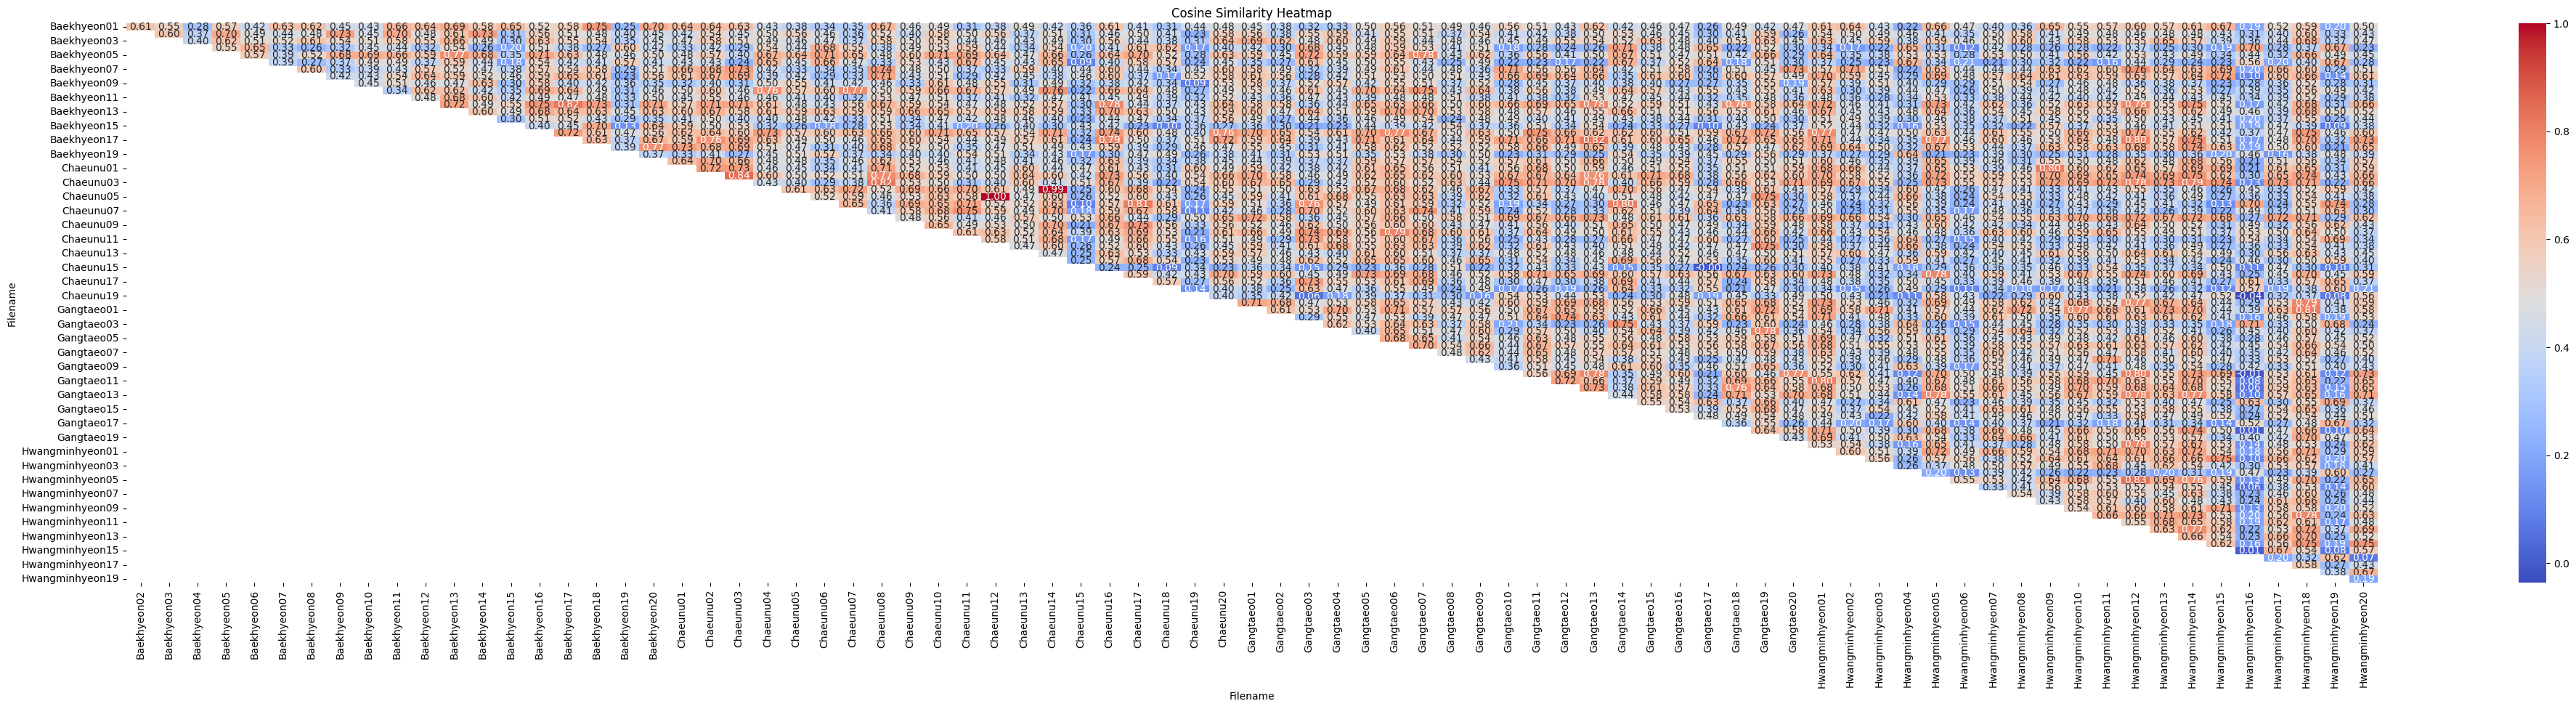

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 피벗 테이블 생성
pivot_table = sim_df.pivot(index='filename1', columns='filename2', values='similarity')

# 히트맵 생성
plt.figure(figsize=(50, 10))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Cosine Similarity Heatmap')
plt.xlabel('Filename')
plt.ylabel('Filename')
plt.show()